In [1]:
import numpy as np

def syn_current(duration=120, dt=0.01, t_on = 10,
                curr_level = 5e-4, seed=None):
    t_offset = 0.
    duration = duration
    t_off = duration - t_on
    t = np.arange(0, duration+dt, dt)

    # external current
    A_soma = np.pi*((70.*1e-4)**2)  # cm2
    I = np.zeros_like(t)
    I[int(np.round(t_on/dt)):int(np.round(t_off/dt))] = curr_level/A_soma # muA/cm2

    return I, t_on, t_off, dt, t, A_soma

In [2]:
def HHsimulator(V0, params, dt, t, I, seed=None):
    """Simulates the Hodgkin-Huxley model for a specified time duration and current

        Parameters
        ---------- 
        V0 : float
            Voltage at first time step
        params : np.array, 1d of length dim_param
            Parameter vector
        dt : float
            Timestep
        t : array
            Numpy array with the time steps
        I : array
            Numpy array with the input current
        seed : int
        """

    gbar_Na = params[0,0]  # mS/cm2
    gbar_Na.astype(float)
    gbar_K = params[0,1]   # mS/cm2
    gbar_K.astype(float)

    # fixed parameters
    g_leak = 0.1    # mS/cm2
    gbar_M = 0.07   # mS/cm2
    tau_max = 6e2   # ms
    Vt = -60.       # mV
    nois_fact = 0.1 # uA/cm2
    E_leak = -70.   # mV
    C = 1.          # uF/cm2
    E_Na = 53       # mV
    E_K = -107      # mV

    tstep = float(dt)

    if seed is not None:
        rng = np.random.RandomState(seed=seed)
    else:
        rng = np.random.RandomState()

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z/2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32*efun(-0.25*v1)/0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28*efun(0.2*v1)/0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128*np.exp(-v1/18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0/(1 + np.exp(-0.2*v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032*efun(-0.2*v1)/0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5*np.exp(-v1/40)

    # steady-states and time constants
    def tau_n(x):
         return 1/(alpha_n(x) + beta_n(x))
    def n_inf(x):
        return alpha_n(x)/(alpha_n(x) + beta_n(x))
    def tau_m(x):
        return 1/(alpha_m(x) + beta_m(x))
    def m_inf(x):
        return alpha_m(x)/(alpha_m(x) + beta_m(x))
    def tau_h(x):
        return 1/(alpha_h(x) + beta_h(x))
    def h_inf(x):
        return alpha_h(x)/(alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0/(1. + np.exp(-0.1*v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max/(3.3*np.exp(0.05*v1) + np.exp(-0.05*v1))


    ####################################
    # simulation from initial point
    V = np.zeros_like(t) # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ( (m[i-1]**3)*gbar_Na*h[i-1]+(n[i-1]**4)*gbar_K+g_leak+gbar_M*p[i-1] )/C
        V_inf = ( (m[i-1]**3)*gbar_Na*h[i-1]*E_Na+(n[i-1]**4)*gbar_K*E_K+g_leak*E_leak+gbar_M*p[i-1]*E_K
                +I[i-1]+nois_fact*rng.randn()/(tstep**0.5) )/(tau_V_inv*C)
        V[i] = V_inf + (V[i-1]-V_inf)*np.exp(-tstep*tau_V_inv)
        n[i] = n_inf(V[i])+(n[i-1]-n_inf(V[i]))*np.exp(-tstep/tau_n(V[i]))
        m[i] = m_inf(V[i])+(m[i-1]-m_inf(V[i]))*np.exp(-tstep/tau_m(V[i]))
        h[i] = h_inf(V[i])+(h[i-1]-h_inf(V[i]))*np.exp(-tstep/tau_h(V[i]))
        p[i] = p_inf(V[i])+(p[i-1]-p_inf(V[i]))*np.exp(-tstep/tau_p(V[i]))

    return np.array(V).reshape(-1,1)

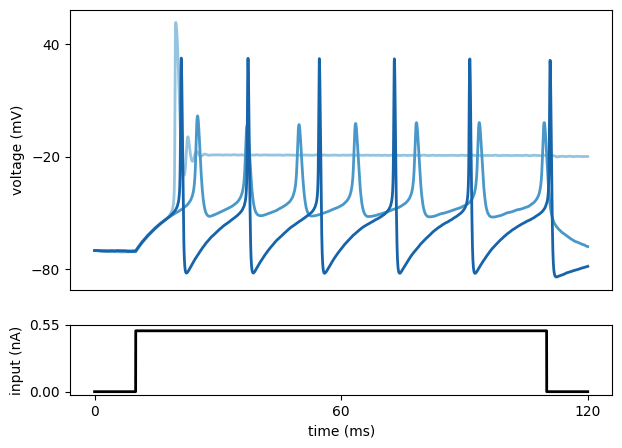

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# input current, time step, time array
I, t_on, t_off, dt, t, A_soma = syn_current()

# simulate Hodgkin-Huxley model for 3 different parameter sets
params = np.array([[[50., 1.]],[[4., 1.5]],[[20., 15.]]])
num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples,len(I)))
for i in range(num_samples):
    sim_samples[i,:] = HHsimulator(V0=-70,params=params[i,:],dt=dt,t=t,I=I,seed=None)[:,0]


# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

# plotting
# %matplotlib inline

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

In [4]:
from delfi.simulator.BaseSimulator import BaseSimulator

class HodgkinHuxley(BaseSimulator):
    def __init__(self, I, dt, V0, seed=None):
        """Hodgkin-Huxley simulator

        Parameters
        ----------
        I : array
            Numpy array with the input current
        dt : float
            Timestep
        V0 : float
            Voltage at first time step
        seed : int or None
            If set, randomness across runs is disabled
        """
        dim_param = 2

        super().__init__(dim_param=dim_param, seed=seed)
        self.I = I
        self.dt = dt
        self.t = np.arange(0, len(self.I), 1)*self.dt
        self.HHsimulator = HHsimulator
        self.init = V0

    def gen_single(self, params):
        """Forward model for simulator for single parameter set

        Parameters
        ----------
        params : list or np.array, 1d of length dim_param
            Parameter vector

        Returns
        -------
        dict : dictionary with data
            The dictionary must contain a key data that contains the results of
            the forward run. Additional entries can be present.
        """
        params = np.asarray(params)

        assert params.ndim == 1, 'params.ndim must be 1'

        hh_seed = self.gen_newseed()

        states = self.HHsimulator(self.init, params.reshape(1, -1), self.dt, self.t, self.I, seed=hh_seed)

        return {'data': states.reshape(-1),
                'time': self.t,
                'dt': self.dt,
                'I': self.I.reshape(-1)}

In [5]:
import delfi.distribution as dd

seed_p = 2
prior_min = np.array([.5,1e-4])
prior_max = np.array([80.,15.])
prior = dd.Uniform(lower=prior_min, upper=prior_max,seed=seed_p)

In [7]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
from scipy import stats as spstats

class HodgkinHuxleyStats(BaseSummaryStats):
    """Moment based SummaryStats class for the Hodgkin-Huxley model

    Calculates summary statistics
    """
    def __init__(self, t_on, t_off, n_mom=4, n_summary=7, seed=None):
        """See SummaryStats.py for docstring"""
        super(HodgkinHuxleyStats, self).__init__(seed=seed)
        self.t_on = t_on
        self.t_off = t_off
        self.n_mom = n_mom
        self.n_summary = np.minimum(n_summary,n_mom + 3)

    def calc(self, repetition_list):
        """Calculate summary statistics

        Parameters
        ----------
        repetition_list : list of dictionaries, one per repetition
            data list, returned by `gen` method of Simulator instance

        Returns
        -------
        np.array, 2d with n_reps x n_summary
        """
        stats = []
        for r in range(len(repetition_list)):
            x = repetition_list[r]

            N = x['data'].shape[0]
            t = x['time']
            dt = x['dt']
            t_on = self.t_on
            t_off = self.t_off

            # initialise array of spike counts
            v = np.array(x['data'])

            # put everything to -10 that is below -10 or has negative slope
            ind = np.where(v < -10)
            v[ind] = -10
            ind = np.where(np.diff(v) < 0)
            v[ind] = -10

            # remaining negative slopes are at spike peaks
            ind = np.where(np.diff(v) < 0)
            spike_times = np.array(t)[ind]
            spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]

            # number of spikes
            if spike_times_stim.shape[0] > 0:
                spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim))>0.5]

            # resting potential and std
            rest_pot = np.mean(x['data'][t<t_on])
            rest_pot_std = np.std(x['data'][int(.9*t_on/dt):int(t_on/dt)])

            # moments
            std_pw = np.power(np.std(x['data'][(t > t_on) & (t < t_off)]),
                              np.linspace(3,self.n_mom,self.n_mom-2))
            std_pw = np.concatenate((np.ones(1),std_pw))
            moments = spstats.moment(x['data'][(t > t_on) & (t < t_off)],
                                     np.linspace(2,self.n_mom,self.n_mom-1))/std_pw

            # concatenation of summary statistics
            sum_stats_vec = np.concatenate((
                    np.array([spike_times_stim.shape[0]]),
                    np.array([rest_pot,rest_pot_std,np.mean(x['data'][(t > t_on) & (t < t_off)])]),
                    moments
                ))
            sum_stats_vec = sum_stats_vec[0:self.n_summary]

            stats.append(sum_stats_vec)

        return np.asarray(stats)

In [8]:
import delfi.generator as dg

# input current, time step
I, t_on, t_off, dt, t, A_soma = syn_current()

# initial voltage
V0 = -70

# seeds
seed_m = 1

# summary statistics hyperparameters
n_mom = 4
n_summary = 7

# define model, prior, summary statistics and generator classes
seed = 3
m = HodgkinHuxley(I, dt, V0=V0, seed=seed_m)
s = HodgkinHuxleyStats(t_on=t_on, t_off=t_off, n_mom=n_mom, n_summary=n_summary)
g = dg.Default(model=m, prior=prior, summary=s)

In [9]:
n_processes = 10

seeds_m = np.arange(1,n_processes+1,1)
m = []
for i in range(n_processes):
    m.append(HodgkinHuxley(I, dt, V0=V0, seed=seeds_m[i]))
g = dg.MPGenerator(models=m, prior=prior, summary=s)

In [10]:
# true parameters and respective labels
true_params = np.array([50., 5.])       
labels_params = [r'$g_{Na}$', r'$g_{K}$']

# observed data: simulation given true parameters
obs = m[0].gen_single(true_params)

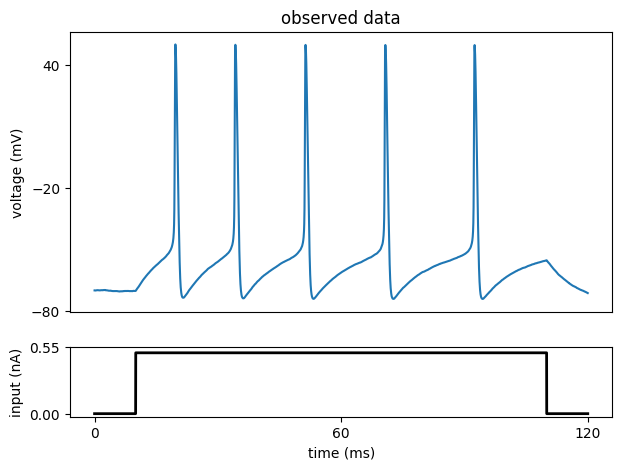

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# %matplotlib inline

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(obs['time'],obs['data'])
plt.ylabel('voltage (mV)')
plt.title('observed data')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(obs['time'],I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(obs['time'])/2, max(obs['time'])])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

In [14]:
obs_stats = s.calc([obs])

In [15]:
seed_inf = 1

pilot_samples = 2000

# training schedule
n_train = 2000
n_rounds = 1

# fitting setup
minibatch = 100
epochs = 100
val_frac = 0.05

# network setup
n_hiddens = [50,50]

# convenience
prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 5         # number of MADES

In [16]:
import delfi.inference as infer

# inference object
res = infer.SNPEC(g,
                obs=obs_stats,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                n_mades=n_mades,
                prior_norm=prior_norm,
                density=density)

# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

/opt/anaconda3/envs/sbi/lib/python3.10/site-packages/theano/scalar/basic.py:2323: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  self.ctor = getattr(np, o_type.dtype)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations